In [1]:
import time, sys
import fsps
import sedpy
import prospect
import dynesty

import numpy as np
from sedpy.observate import load_filters

from prospect import prospect_args
from prospect.fitting import fit_model
from prospect.io import write_results as writer

In [2]:
#run_params ={'verbose': True,
 #           'debug': True,
  #          'outfile':'output/NGC2768',
   #         'output_pickles': False,
    #        'nested_bound': 'multi','nested_sample': 'unif', 'nested_nlive_init': 400,
     #       'nested_nlive_batch': 300, 'nested_bootstrap':0, 'nested_dlogz_init':0.05,
      #      'nested_weight_kwargs': {"pfrac": 1.0}, 
       #    'snr': 20, 'logmass': 10,
        #    'nwalkers':280, 'nburn':[128,64,32],'niter':800, 'interval': 0.25, 
         #   'initial_disp': 0.1,
          #  'add_neb': False, 'add_duste': , 'zcontinuous':1,}

In [2]:
run_params = {}
run_params["snr"] = 20

In [3]:
def build_model(object_redshift=0.0045, fixed_metallicity = -1.0, add_neb=False,  **extras):
    
    from prospect.models.sedmodel import SedModel
    from prospect.models.templates import TemplateLibrary,adjust_continuity_agebins
    from prospect.models import priors, transforms
    
    

    model_params = TemplateLibrary["continuity_sfh"]
    model_params.update(TemplateLibrary["dust_emission"])

    model_params["duste_qpah"]["isfree"] = True


    model_params["logmass"]={"N": 1, "isfree": True, "init":10, "units": 'Msun',
                                   "init_disp":0.1}

    model_params["mass"]={'N': 5, 'isfree': False, 'init': 1e8, 
                                         'units': r'M$_\odot$',
                                        'depends_on': transforms.logsfr_ratios_to_masses}
    model_params["sfh"] = {"N":1, "isfree": False, "init":3, "units": "FSPS index"}
    model_params["logsfr_ratios"] = {'N': 2, 'isfree': True, 'init': [1., 0.],
                                                  'prior': priors.StudentT(mean=np.full(2, 0.0),
                                                                           scale=np.full(2,0.3),                                                                    
                                                                           df= np.full(2,2))}
    model_params["agebins"]["init"] = {'N': 3, 'isfree': True,
                                          'init': [[0.0, 8.0], [8.0, 9.0],[9.0,10.0]], 'units': 'log(yr)'}
    
    
    model_params["duste_qpah"]["init"] = 1.0
    model_params["dust2"]["init"] = 0.5
    model_params["logzsol"]["init"] = -1.0
    
    model_params["dust2"]["prior"] = priors.TopHat(mini=0.0, maxi=3)
    model_params["logzsol"]["prior"] = priors.TopHat(mini= -2, maxi = 0.19)
    model_params["duste_qpah"]["prior"] = priors.TopHat(mini=0.5, maxi=7.0)
    #model_params["duste_umin"]["prior"] = priors.TopHat(mini=0.1, maxi=25)
    model_params["logmass"]["prior"] = priors.LogUniform(mini=7, maxi=12)
    
    
    model_params=adjust_continuity_agebins(model_params, tuniv=13.713, nbins=8)
 

    
    model_params["logmass"]["disp_floor"] = 0.5
    model_params["dust2"]["disp_floor"] = 0.1
    

    if fixed_metallicity is not None:
        model_params["logzsol"]["isfree"] = True
        model_params["logzsol"]['init'] = fixed_metallicity 

    if object_redshift is not None:
        model_params["zred"]['isfree'] = False
        model_params["zred"]['init'] = object_redshift 
        
    
    if add_neb:
        model_params.update(TemplateLibrary['nebular'])
  
    model = SedModel(model_params)
    
    return model

run_params["object_redshift"] = 0.0045
run_params["fixed_metallicity"] = -1.0
run_params["add_neb"] = False
    
model = build_model(**run_params)
print(model)    
print("\nInitial free parameter vector theta:\n  {}\n".format(model.theta))
print("Initial parameter dictionary:\n{}".format(model.params))

:::::::
<class 'prospect.models.sedmodel.SedModel'>

Free Parameters: (name: prior) 
-----------
  logsfr_ratios: <class 'prospect.models.priors.StudentT'>(scale=[0.3 0.3 0.3 0.3 0.3 0.3 0.3],mean=[0. 0. 0. 0. 0. 0. 0.],df=[2. 2. 2. 2. 2. 2. 2.])
  logzsol: <class 'prospect.models.priors.TopHat'>(mini=-2,maxi=0.19)
  dust2: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=3)
  duste_qpah: <class 'prospect.models.priors.TopHat'>(mini=0.5,maxi=7.0)
  logmass: <class 'prospect.models.priors.LogUniform'>(mini=7,maxi=12)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  add_dust_emission: True 
  agebins: [[ 0.          7.4772    ]
 [ 7.4772      8.        ]
 [ 8.          8.41331028]
 [ 8.41331028  8.82662056]
 [ 8.82662056  9.23993084]
 [ 9.23993084  9.65324112]
 [ 9.65324112 10.0665514 ]
 [10.0665514  10.13713248]] 
  duste_gamma: 0.001 
  duste_umin: 1.0 
  sfh: 3 
  dust_type: 0 
  mass: 100000000.0 <function logsfr_ratios_to_masses at 0x7f1b16014510>
  zred: 0.0045 


In [4]:
itheta = model.theta.copy()
print(itheta)

[ 0.   0.   0.   0.   0.   0.   0.  -1.   0.5  1.  10. ]


In [5]:
from prospect.utils.obsutils import fix_obs
def build_obs(snr=20, **extras):
    obs = {}

    galex = ['galex_NUV', 'galex_FUV']
    twomass = ['twomass_{}'.format(b) for b in ['J', 'H', 'Ks']]
    sdss = ['sdss_{0}0'.format(b) for b in ['u', 'g','r', 'i', 'z']]
    wise = ['wise_w'+n for n in ['1','2', '3', '4']]
    filternames = galex + twomass + sdss + wise
    
    obs["filters"] = sedpy.observate.load_filters(filternames)

    mags = np.array([16.58, 17.49, 9.47, 9.23, 9.45, 15.6,
                    14.19, 13.04, 12.16, 10.32, 10.05, 10.72, 11.85, 12.23])
    obs["maggies"] = 10**(-0.4*mags)
    obs["maggies_unc"] = (1/snr) * obs["maggies"]
    obs["phot_mask"] = np.ones_like(obs['filters'], dtype=bool)
    obs["phot_wave"] = np.array([f.wave_effective for f in obs["filters"]])
    obs["wavelength"] = None
    obs["spectrum"] = None
    obs['unc'] = None
    obs['mask'] = None
    obs = fix_obs(obs)

    return obs

In [6]:
def build_sps(zcontinuous = 1, **extras):
    from prospect.sources import FastStepBasis
    sps = FastStepBasis(zcontinuous=zcontinuous)
    return sps

In [9]:
def build_noise(**extras):
    return None, None
#def build_all(**kwargs):
    #return(build_obs(**kwargs), build_model(**kwargs),
            #build_sps(**kwargs), build_noise(**kwargs))

In [28]:
from prospect import prospect_args
if __name__=='__main__':

    parser = prospect_args.get_parser()

    parser.add_argument('--zred', type=float, default=0.009,
                    help="Redshift for the model (and mock).")
    parser.add_argument('--snr', type=float, default=10,
                    help="S/N ratio for the mock photometry.")
    parser.add_argument('--add_duste', action="store_false",
                    help="If set, add dust emission to the model.")
    parser.add_argument('--dust2', type=float, default=1.5,
                    help="Dust attenuation V band optical depth")
    parser.add_argument('--logzsol', type=float, default=-0.1,
                    help="Metallicity of the mock; log(Z/Z_sun)")
    parser.add_argument('--logmass', type=float, default=12,
                    help="Stellar mass of the mock (logged); solar masses formed")
    
    args, _ = parser.parse_known_args()
    run_params = vars(args)
    print(run_params)
    obs, model, sps, noise = build_all(**run_params)
    
    run_params["sps_libraries"] = sps.ssp.libraries

    print(model)
    
    if args.debug:
        sys.exit()

{'nested_posterior_thresh': 0.05, 'nburn': [16, 32, 64], 'min_opts': {}, 'zred': 0.009, 'nested_maxbatch': 10, 'output_pickle': False, 'optimize': False, 'nested_nlive_init': 100, 'debug': False, 'interval': 0.2, 'zcontinuous': 1, 'verbose': 1, 'nmin': 1, 'logzsol': -0.1, 'logmass': 12, 'min_method': 'lm', 'nested_maxcall': 50000000, 'add_duste': True, 'niter': 512, 'nested_method': 'slice', 'emcee': False, 'dynesty': False, 'nested_dlogz_init': 0.05, 'initial_disp': 0.1, 'outfile': 'prospector_test_run', 'nwalkers': 64, 'dust2': 1.5, 'nested_nlive_batch': 100, 'restart_from': '', 'nested_bootstrap': 0, 'nested_bound': 'multi', 'snr': 10}


NameError: name 'build_all' is not defined

In [7]:
from prospect.likelihood import lnlike_spec, lnlike_phot, write_log

verbose = True
def lnprobfn(theta, model=None, obs=None, sps=None, 
             nested=False, verbose=verbose):
    
    lnp_prior = model.prior_product(theta, nested=nested)
    if not np.isfinite(lnp_prior):
        return -np.infty
    
    spec, phot, mfrac = model.mean_model(theta, obs, sps=sps)
 
    lnp_spec = lnlike_spec(spec, obs=obs)
    lnp_phot = lnlike_phot(phot, obs=obs)

    return lnp_prior + lnp_phot + lnp_spec

run_params["verbose"] = verbose

In [8]:
from prospect.likelihood import chi_spec, chi_phot
def chivecfn(theta):
    
    lnp_prior = model.prior_product(theta)
    if not np.isfinite(lnp_prior):
        return np.zeros(model.ndim) - np.infty

    try:
        spec, phot, x = model.mean_model(theta, obs, sps=sps)
    except(ValueError):
        return np.zeros(model.ndim) - np.infty

    chispec = chi_spec(spec, obs)
    chiphot = chi_phot(phot, obs)
    return np.concatenate([chispec, chiphot])
from prospect.fitting import lnprobfn

In [9]:
from prospect.fitting import fit_model
obs = build_obs(**run_params)
sps = build_sps(**run_params)
model = build_model(**run_params)
print(sps.ssp.libraries)
run_params["optimize"] = False
run_params["emcee"] = True
run_params["dynesty"] = False
run_params["nwalkers"] = 512
run_params["niter"] = 2000
run_params["nburn"] = [500, 300]
output = fit_model(obs, model, sps, lnprobfn=lnprobfn, **run_params)
hfile = "NGC2768_mcmc.h5".format(output["sampling"][1])
print('done mcmc in {0}s'.format(output["sampling"][1]))

(b'mist', b'miles')
number of walkers=512


/project/kaboom/etc/conda/env/astroconda/lib/python3.5/site-packages/prospect-0.3.0-py3.5.egg/prospect/models/priors.py:90: RuntimeWarning: divide by zero encountered in log


done burn #0 (500 iterations)
done burn #1 (300 iterations)
number of walkers=512
starting production
done production
done mcmc in 23569.567394971848s


In [10]:
import prospect.io.write_results as writer
hfile = "NGC2768_mcmc.h5"
writer.write_hdf5(hfile, run_params, model, obs,
                  output["sampling"][0], output["optimization"][0],
                  tsample=output["sampling"][1],
                  toptimize=output["optimization"][1])
print('Finished')

/project/kaboom/etc/conda/env/astroconda/lib/python3.5/site-packages/prospect-0.3.0-py3.5.egg/prospect/io/write_results.py:52: RuntimeWarning: Could not store paramfile text
/project/kaboom/etc/conda/env/astroconda/lib/python3.5/site-packages/prospect-0.3.0-py3.5.egg/prospect/io/write_results.py:225: RuntimeWarning: Could not JSON serialize model_params, pickled instead
/project/kaboom/etc/conda/env/astroconda/lib/python3.5/site-packages/prospect-0.3.0-py3.5.egg/prospect/io/write_results.py:254: UserWarning: Could not JSON serialize ndof, pickled instead


Finished


MAP value: [ 8.60573470e-02  8.75071358e-01  5.24373914e-02 -1.94374244e-02
  8.92270362e-02 -2.65474835e-04 -3.28144654e+00  1.89183771e-01
  5.44458584e-01  2.21503196e+00  1.03897385e+01]


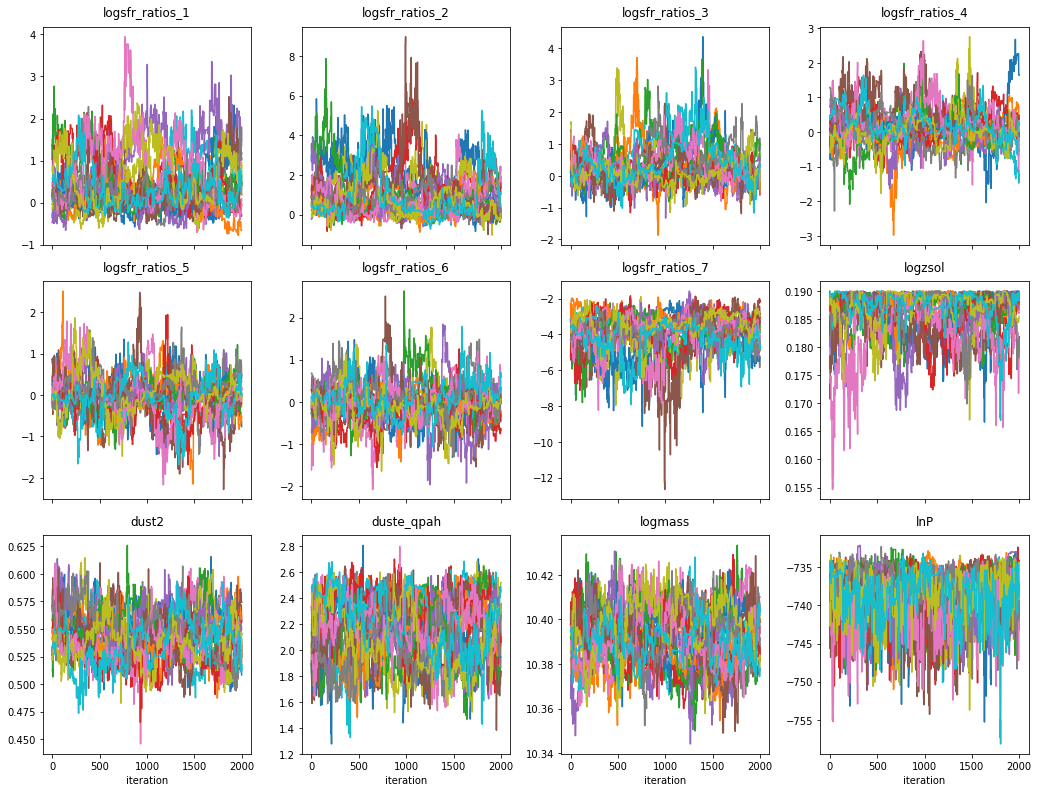

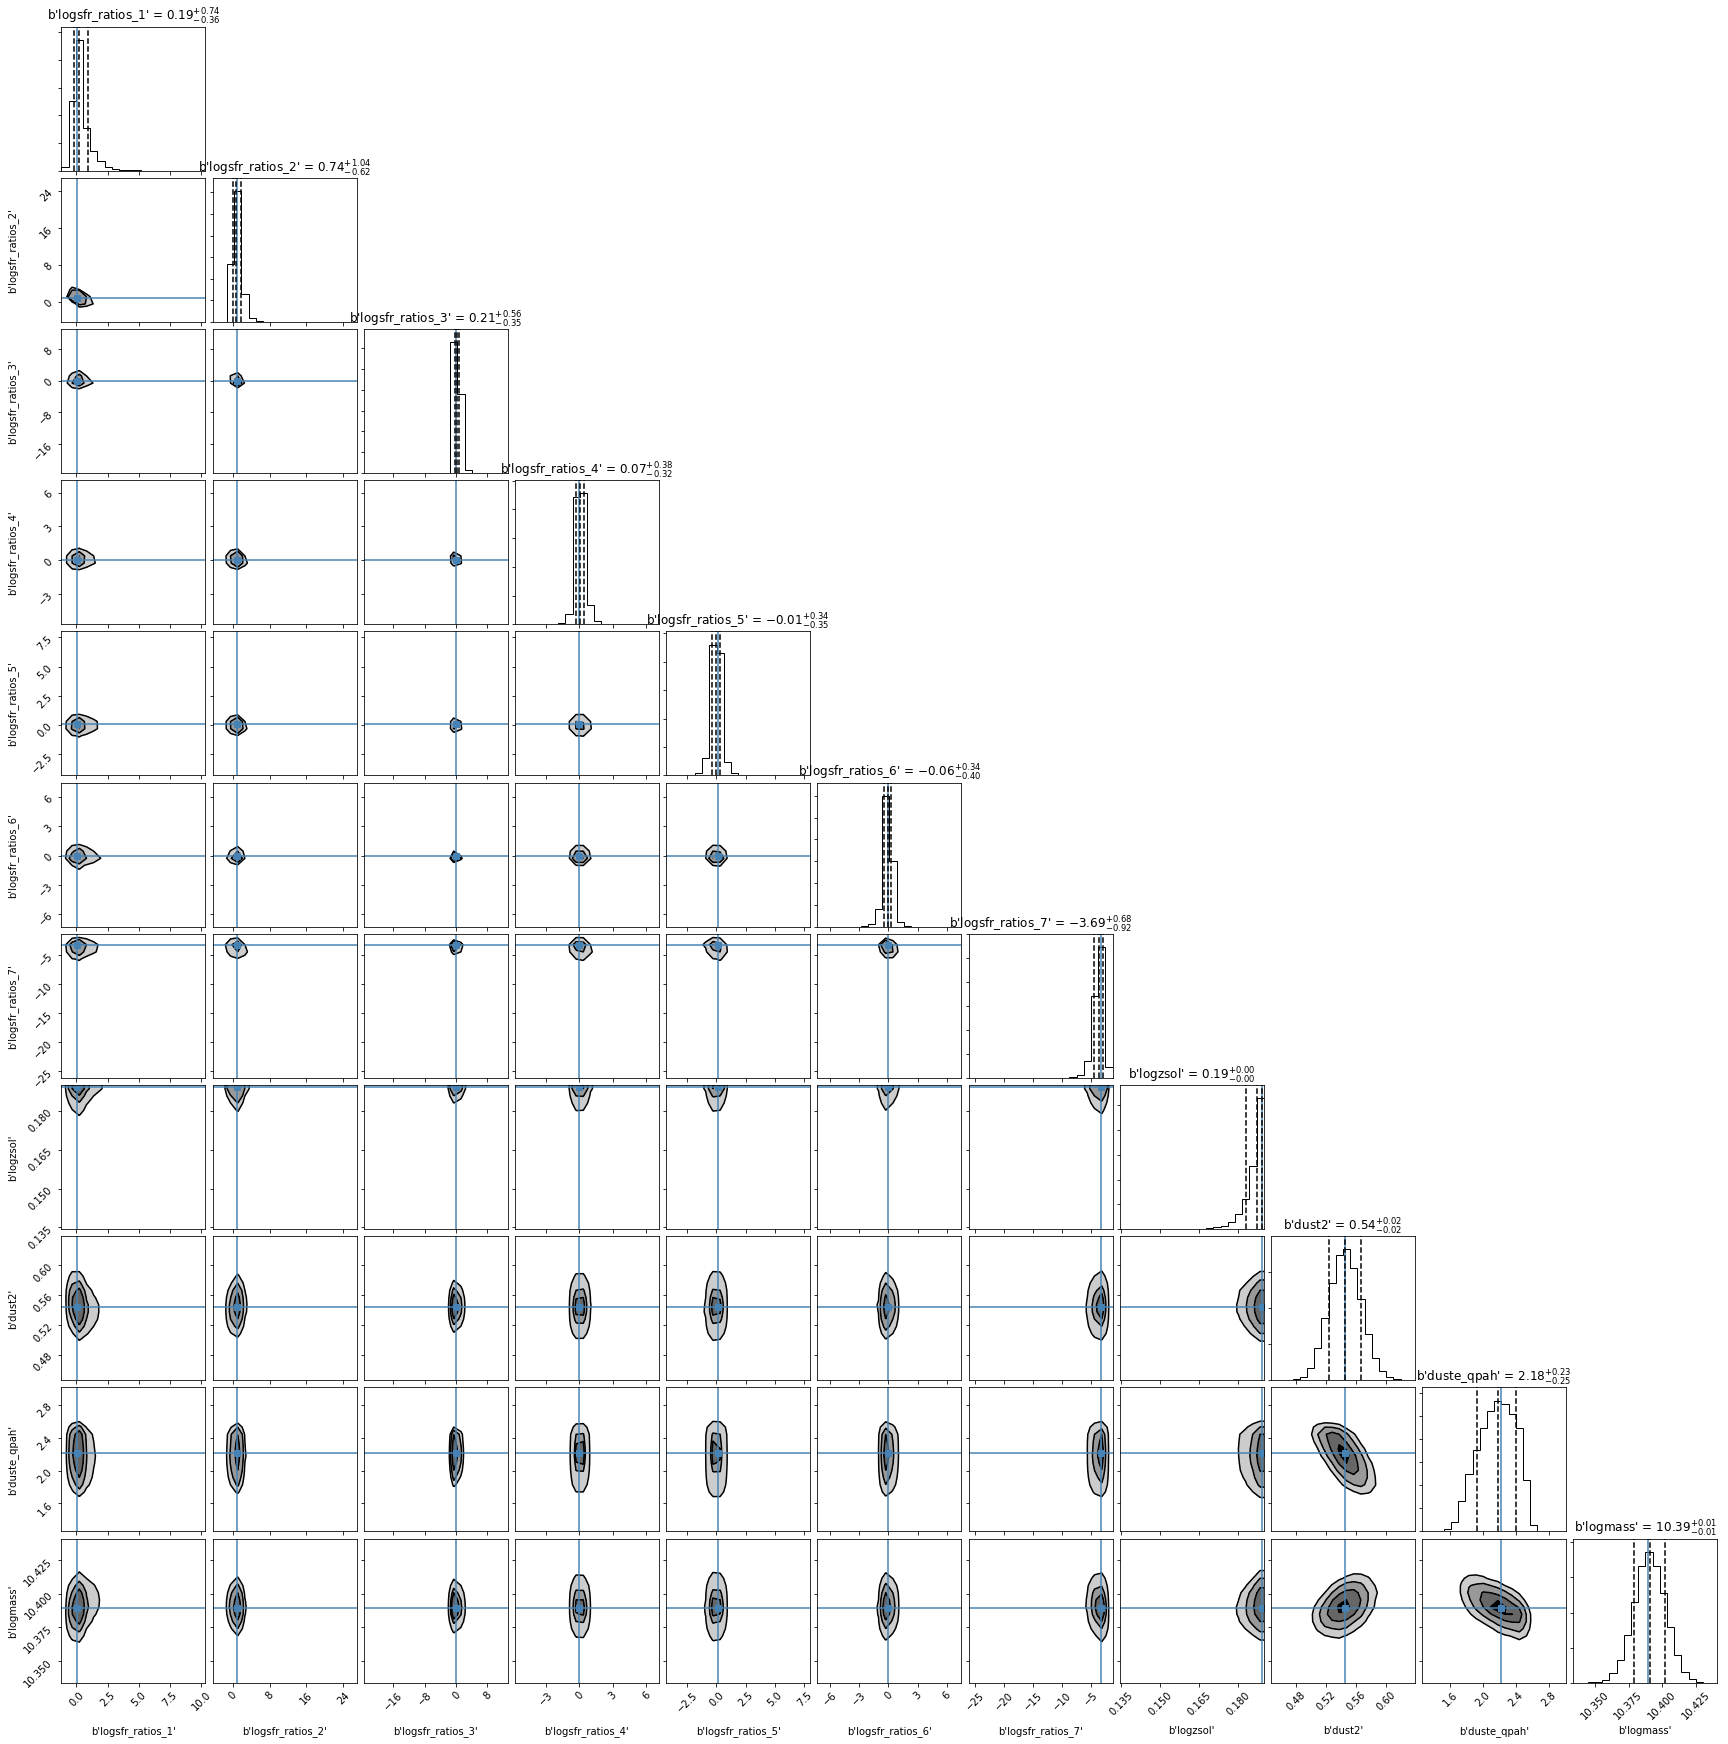

In [13]:
(res, topt) = output["sampling"]
import prospect.io.read_results as reader
res, obs, model = reader.results_from("NGC2768_mcmc.h5")
ind_max = res["lnprobability"].argmax()
chosen = np.random.choice(res["run_params"]["nwalkers"], size=20, replace=False)
walker, iteration = np.unravel_index(ind_max, res["lnprobability"].shape)
theta_max = res["chain"][walker, iteration, :]
tracefig = reader.traceplot(res, chains = chosen)
thin = 1
#cornerfig = reader.subcorner(res, , thin=thin)
cornerfig = reader.subcorner(res, thin=thin, truths=theta_max)
print('MAP value: {}'.format(theta_max))

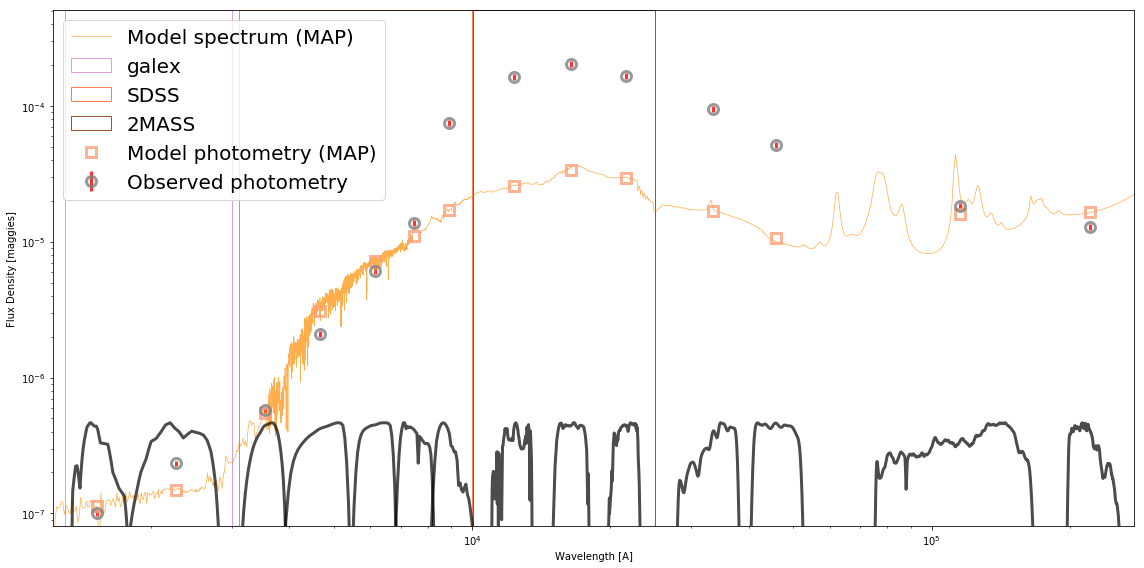

In [12]:
from matplotlib.pyplot import *
randint = np.random.randint
res_type = "emcee"
nwalkers, niter = run_params['nwalkers'], run_params['niter']
theta = res['chain'][randint(nwalkers), randint(niter)]

obs = build_obs(**run_params)
sps = build_sps(**run_params)
model = build_model(**run_params)
#theta = model.theta.copy()
wspec = sps.wavelengths
wphot = obs["phot_wave"]
mspec, mphot, mextra = model.mean_model(theta, obs, sps=sps)
mspec_map, mphot_map, _ = model.mean_model(theta_max, obs, sps=sps)

figure(figsize=(16,8))

xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
ymin, ymax = obs["maggies"].min()*0.8, obs["maggies"].max()/0.4


#loglog(wspec, mspec, label='Model spectrum (random draw)',
 #      lw=0.7, color='navy', alpha=0.7)
loglog(wspec, mspec_map, label='Model spectrum (MAP)',
       lw=0.7, color='darkorange', alpha=0.7)
#errorbar(wphot, mphot, label='Model photometry (random draw)',
 #        marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
  #       markerfacecolor='none', markeredgecolor='blue', 
   #      markeredgewidth=3)
errorbar(wphot, mphot_map, label='Model photometry (MAP)',
         marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='lightsalmon', 
         markeredgewidth=3)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], 
         label='Observed photometry', ecolor='red', 
         marker='o', markersize=10, ls='', lw=3, alpha=0.8, 
         markerfacecolor='none', markeredgecolor='gray', 
         markeredgewidth=3)

#plot transmission curves
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=3, color='black', alpha=0.7)

xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
axvspan(xmin=1300, xmax=3000, fc='none',ec = 'plum', label = 'galex')
axvspan(xmin=3100, xmax=10000,fc = 'none', ec = 'coral', label = 'SDSS')
axvspan(xmin=10050, xmax=25000, fc='none', ec = 'sienna', label = '2MASS')
#axvspan(xmin=27000, xmax=250000,fc = 'none', ec = 'olivedrab', label = 'WISE')
legend(loc='best', fontsize=20)
tight_layout()


In [16]:
obs = build_obs(**run_params)
sps = build_sps(**run_params)
model = build_model(**run_params)
itheta = model.theta.copy()
spec, fluxes,_ = model.mean_model(itheta, obs=obs, sps=sps)
print(spec, fluxes)

[1.79272952e-14 2.43137303e-14 3.16873011e-14 ... 1.03925578e-07
 1.01207312e-07 9.85587868e-08] [3.26848524e-06 2.58934944e-06 2.92960477e-05 3.11244342e-05
 2.35359707e-05 5.65166218e-06 1.34907353e-05 1.86711142e-05
 2.25574459e-05 2.55912827e-05 1.50745583e-05 9.06690584e-06
 7.71034373e-05 1.34800846e-04]


In [16]:
itheta = model.theta.copy()
print(itheta)

[ 1.63697065  3.90515989 -0.26079413  0.59566738  0.08524447  0.08187847
 -0.16562814 -1.99397891 11.10138887  1.54942891  3.62815605]
